In [1]:
# import required libraries

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

from matplotlib import pyplot as plt
import numpy as np

In [2]:
# Load the dataset
data = pd.read_csv('parkinsons.data')  # Replace 'your_dataset.csv' with the actual file name

In [3]:
# Separate features (X) and target (y)
X = data.drop(['name', 'status'], axis=1)  # Remove 'name' column and keep all features except 'status'
y = data['status']  # Target variable

In [4]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7,stratify=y)

In [5]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Create and train the Logistic Regression model
# Used solver: lbfgs
# This solver is better for multiclass classification and large dataset because of memory optimization

model = LogisticRegression(solver='lbfgs')
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [7]:
# Model intercept_
model.intercept_

array([2.68647824])

In [8]:
# Model coef_
model.coef_

array([[-1.12522505e-01, -9.10746316e-02, -2.06008265e-01,
        -3.06311974e-01, -1.05345480e-01,  6.17406654e-01,
         1.02135929e-01,  6.14550076e-01,  1.64680349e-01,
         2.12622651e-01, -3.10672878e-01,  4.28866712e-01,
         7.62195434e-01, -3.11076211e-01,  6.81162711e-01,
         3.48171341e-01, -3.35485848e-01,  5.15996267e-04,
         7.79610283e-01,  7.41609980e-01,  3.41381843e-01,
         4.59917331e-01]])

In [9]:
N = len(data.keys())
print(N)
print(list(data.keys()))

24
['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE']


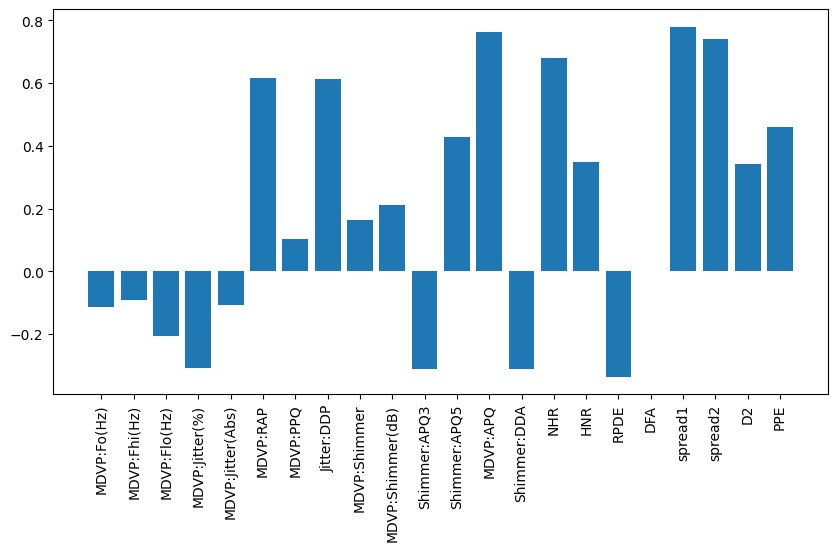

In [10]:
# Interpretation of intercept and coef values
N = len(list(X.keys()))
values = model.coef_[0]
plt.figure(figsize=(10, 5))
plt.bar(np.arange(0, N), values)
plt.xticks(np.arange(0, N), list(X.keys()), rotation='vertical')

plt.show()

In [11]:
# Predict on the test set
y_pred = model.predict(X_test_scaled)

In [12]:
# Evaluate the model
accuracy_lbfgs = accuracy_score(y_test, y_pred)
precision_score_lbfgs = precision_score(y_test, y_pred)
recall_score_lbfgs = recall_score(y_test, y_pred)
f1_score_lbfgs = f1_score(y_test, y_pred)
conf_matrix_lbfgs = confusion_matrix(y_test, y_pred)
class_report_lbfgs = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy_lbfgs:.2f}")
print(f"Precision score: {precision_score_lbfgs:.2f}")
print(f"Recall score: {recall_score_lbfgs:.2f}")
print(f"F1 score: {f1_score_lbfgs:.2f}")
print("Confusion Matrix:\n", conf_matrix_lbfgs)
print("Classification Report:\n", class_report_lbfgs)


Accuracy: 0.86
Precision score: 0.89
Recall score: 0.93
F1 score: 0.91
Confusion Matrix:
 [[10  5]
 [ 3 41]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.89      0.93      0.91        44

    accuracy                           0.86        59
   macro avg       0.83      0.80      0.81        59
weighted avg       0.86      0.86      0.86        59



In [13]:
# 'liblinear'good for very binary classification and high-dimensional datasets with a small number of samples. 

model_liblinear = LogisticRegression(solver='liblinear')
model_liblinear.fit(X_train_scaled, y_train)




LogisticRegression(solver='liblinear')

In [14]:
# Model intercept_
model_liblinear.intercept_

array([2.13961634])

In [15]:
# Model coef_
model_liblinear.coef_

array([[-0.10371348, -0.09535217, -0.29142544, -0.39205314, -0.14068638,
         0.58167875, -0.04549382,  0.57887438,  0.13845307,  0.1419557 ,
        -0.25569731,  0.32099758,  0.643641  , -0.25612995,  0.36673499,
         0.1864403 , -0.30078586,  0.0501064 ,  0.75681065,  0.6594786 ,
         0.30634716,  0.35336609]])

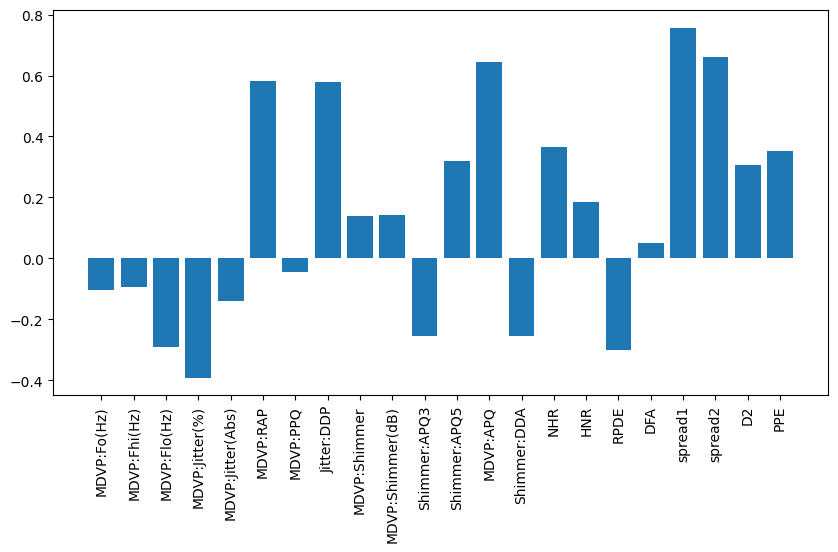

In [16]:
# Interpretation of intercept and coef values for liblinear solver
N = len(list(X.keys()))
values = model_liblinear.coef_[0]
plt.figure(figsize=(10, 5))
plt.bar(np.arange(0, N), values)
plt.xticks(np.arange(0, N), list(X.keys()), rotation='vertical')

plt.show()

In [17]:
# Predict on the test set
y_pred = model_liblinear.predict(X_test_scaled)

In [18]:
# Evaluate the model for liblinear solver
accuracy_liblinear = accuracy_score(y_test, y_pred)
precision_score_liblinear = precision_score(y_test, y_pred)
recall_score_liblinear = recall_score(y_test, y_pred)
f1_score_liblinear = f1_score(y_test, y_pred)
conf_matrix_liblinear = confusion_matrix(y_test, y_pred)
class_report_liblinear = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy_liblinear:.2f}")
print(f"Precision score: {precision_score_liblinear:.2f}")
print(f"Recall score: {recall_score_liblinear:.2f}")
print(f"F1 score: {f1_score_liblinear:.2f}")
print("Confusion Matrix:\n", conf_matrix_liblinear)
print("Classification Report:\n", class_report_liblinear)


Accuracy: 0.86
Precision score: 0.89
Recall score: 0.93
F1 score: 0.91
Confusion Matrix:
 [[10  5]
 [ 3 41]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.89      0.93      0.91        44

    accuracy                           0.86        59
   macro avg       0.83      0.80      0.81        59
weighted avg       0.86      0.86      0.86        59



In [19]:
# Save model
import pickle

with open('../models/log_reg_lbfgs_classifier.model.pickle', 'wb') as model_file:
    pickle.dump(model, model_file)
    
with open('../models/log_reg_lbfgs_classifier.scaler.pickle', 'wb') as model_file:
    pickle.dump(scaler, model_file)